In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
spark = SparkSession.builder \
    .appName("WeatherAnalysis") \
    .getOrCreate()

In [3]:
# Load the data
weather_df = spark.read.csv("weather.csv", header=True, inferSchema=True)

# Show the schema to understand the data structure
weather_df.printSchema()
weather_df.count()

root
 |-- STATION: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- DATE: date (nullable = true)
 |-- ACMC: double (nullable = true)
 |-- ACMH: double (nullable = true)
 |-- ACSC: double (nullable = true)
 |-- ACSH: double (nullable = true)
 |-- AWND: double (nullable = true)
 |-- DAPR: double (nullable = true)
 |-- FMTM: double (nullable = true)
 |-- MDPR: double (nullable = true)
 |-- MDSF: double (nullable = true)
 |-- PGTM: double (nullable = true)
 |-- PRCP: double (nullable = true)
 |-- PSUN: double (nullable = true)
 |-- SNOW: double (nullable = true)
 |-- SNWD: double (nullable = true)
 |-- TAVG: integer (nullable = true)
 |-- TMAX: integer (nullable = true)
 |-- TMIN: integer (nullable = true)
 |-- TOBS: integer (nullable = true)
 |-- TSUN: double (nullable = true)
 |-- WDF1: double (nullable = true)
 |-- WDF2: double (nullable = true)
 |-- WDF5: double (nullable = true)
 |-- WDFG: double (nullable = true)
 |-- WDFM: double (nullable = true)
 |-- WESD: double 

208859

In [4]:
# Check for nulls in the dataset
weather_df.describe().show()

# Drop rows with missing critical values
weather_df_clean = weather_df.dropna(subset=["TAVG", "DATE", "STATION", "NAME"])

# You could also fill missing values if necessary, depending on the column.
# weather_df_clean = weather_df.fillna({'TAVG': 0})


weather_df_clean.count()

+-------+-----------+--------------------+----+-----------------+----+-----------------+-----------------+------------------+-----------------+------------------+----+------------------+-------------------+-----------------+-------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-------------------+------------------+------------------+------------------+------------------+------------------+--------------------+----+--------------------+----+----+----+----+-----+----+----+----+-----+----+----+-----+----+-----+----+----+--------------------+----+----+----+----+----+
|summary|    STATION|                NAME|ACMC|             ACMH|ACSC|             ACSH|             AWND|              DAPR|             FMTM|              MDPR|MDSF|              PGTM|               PRCP|             PSUN|               SNOW|             

64288

In [5]:
# Define regions based on station names
desert_stations = ["PHOENIX AIRPORT, AZ US", "WHITE SANDS NATIONAL MON., NM US"]
coastal_stations = ["SEATTLE TACOMA AIRPORT, WA US", "MIAMI INTERNATIONAL AIRPORT, FL US"]
mountain_stations = ["DENVER INTERNATIONAL AIRPORT, CO US", "MOUNT SHASTA, CA US"]

# Filter data based on the station region
desert_df = weather_df_clean.filter(weather_df_clean["NAME"].isin(desert_stations))
coastal_df = weather_df_clean.filter(weather_df_clean["NAME"].isin(coastal_stations))
mountain_df = weather_df_clean.filter(weather_df_clean["NAME"].isin(mountain_stations))




In [6]:
from pyspark.sql import functions as F

# Calculate the average temperature for each region
desert_avg_temp = desert_df.groupBy("DATE").agg(F.avg("TAVG").alias("AVG_TAVG"))
coastal_avg_temp = coastal_df.groupBy("DATE").agg(F.avg("TAVG").alias("AVG_TAVG"))
mountain_avg_temp = mountain_df.groupBy("DATE").agg(F.avg("TAVG").alias("AVG_TAVG"))



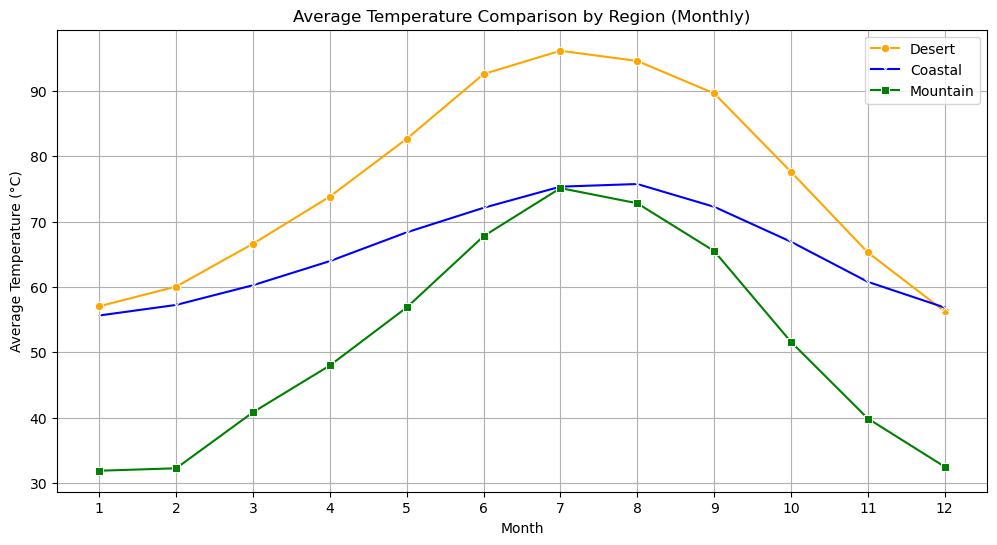

In [7]:
# Downsampling to monthly averages for better visualization
desert_avg_temp_month = desert_avg_temp.withColumn("Month", F.month("DATE"))
coastal_avg_temp_month = coastal_avg_temp.withColumn("Month", F.month("DATE"))
mountain_avg_temp_month = mountain_avg_temp.withColumn("Month", F.month("DATE"))

# Group by month and calculate average temperature
desert_avg_temp_month = desert_avg_temp_month.groupBy("Month").agg(F.avg("AVG_TAVG").alias("AVG_TAVG"))
coastal_avg_temp_month = coastal_avg_temp_month.groupBy("Month").agg(F.avg("AVG_TAVG").alias("AVG_TAVG"))
mountain_avg_temp_month = mountain_avg_temp_month.groupBy("Month").agg(F.avg("AVG_TAVG").alias("AVG_TAVG"))

# Convert to pandas for easier plotting
desert_pd_month = desert_avg_temp_month.toPandas()
coastal_pd_month = coastal_avg_temp_month.toPandas()
mountain_pd_month = mountain_avg_temp_month.toPandas()

import seaborn as sns
import matplotlib.pyplot as plt

# Convert the Spark DataFrame to pandas DataFrame
desert_pd_month = desert_avg_temp_month.toPandas()
coastal_pd_month = coastal_avg_temp_month.toPandas()
mountain_pd_month = mountain_avg_temp_month.toPandas()

# Set up the plot
plt.figure(figsize=(12, 6))

# Plot using Seaborn's lineplot
sns.lineplot(x='Month', y='AVG_TAVG', data=desert_pd_month, label="Desert", color="orange", marker="o")
sns.lineplot(x='Month', y='AVG_TAVG', data=coastal_pd_month, label="Coastal", color="blue", marker="x")
sns.lineplot(x='Month', y='AVG_TAVG', data=mountain_pd_month, label="Mountain", color="green", marker="s")

# Adding labels and title
plt.xlabel('Month')
plt.ylabel('Average Temperature (°C)')
plt.title('Average Temperature Comparison by Region (Monthly)')
plt.legend()
plt.xticks(range(1, 13))  # Show all months on the x-axis
plt.grid(True)

# Show the plot
plt.show()


In [64]:
import os
os.environ['PYSPARK_PYTHON'] = 'C:/path/to/python3.11'  # Replace with the path to your Python 3.11
os.environ['PYSPARK_DRIVER_PYTHON'] = 'C:/path/to/python3.11'  # Replace with the path to your Python 3.11


In [9]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

df=weather_df
df_clean = df.dropna(subset=["TMAX", "TMIN", "TAVG"])

# Assemble features (TMAX, TMIN) into a feature vector
assembler = VectorAssembler(inputCols=["TMAX", "TMIN"], outputCol="features")
df_assembled = assembler.transform(df_clean)

# Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="TAVG")

# Train the model
model = lr.fit(df_assembled)

# Display available station names (unique stations)
stations = df_clean.select("NAME").distinct().rdd.flatMap(lambda x: x).collect()
print("Available stations:")
for i, station in enumerate(stations, 1):
    print(f"{i}. {station}")

# User input: Ask the user to select a station by number
station_index = int(input("Enter the number of the station to predict temperature: ")) - 1

# Validate the input
if station_index < 0 or station_index >= len(stations):
    print("Invalid selection. Please select a valid station number.")
else:
    station_name = stations[station_index]
    
    # Filter the data for the selected station
    df_selected = df_clean.filter(df_clean['NAME'] == station_name)

    # Assemble features for the selected station
    df_assembled_selected = assembler.transform(df_selected)

    # Make predictions
    prediction = model.transform(df_assembled_selected)
    
    # Show the predicted temperature for the selected station
    prediction.select("NAME", "TAVG", "prediction").show()

Available stations:
1. CHICAGO OHARE INTERNATIONAL AIRPORT, IL US
2. NY CITY CENTRAL PARK, NY US
3. MINNEAPOLIS ST. PAUL INTERNATIONAL AIRPORT, MN US
4. NOME AIRPORT, AK US
5. DAL FTW WSCMO AIRPORT, TX US
6. LOS ANGELES DOWNTOWN USC, CA US
7. MIAMI INTERNATIONAL AIRPORT, FL US
8. PHOENIX AIRPORT, AZ US
9. KODIAK AIRPORT, AK US
10. DENVER INTERNATIONAL AIRPORT, CO US
11. SEATTLE TACOMA AIRPORT, WA US
Enter the number of the station to predict temperature: 6
+--------------------+----+------------------+
|                NAME|TAVG|        prediction|
+--------------------+----+------------------+
|LOS ANGELES DOWNT...|  51| 50.66130554344272|
|LOS ANGELES DOWNT...|  55|55.046527180404254|
|LOS ANGELES DOWNT...|  57| 56.62076278126215|
|LOS ANGELES DOWNT...|  50|  50.2153068817996|
|LOS ANGELES DOWNT...|  58| 58.06000431587518|
|LOS ANGELES DOWNT...|  57| 57.10050995946649|
|LOS ANGELES DOWNT...|  58| 58.06000431587518|
|LOS ANGELES DOWNT...|  60| 60.01274154525378|
|LOS ANGELES DOWNT...|

In [23]:
import pandas as pd
df= pd.read_csv('weather.csv')

selected_columns = ['STATION', 'NAME', 'DATE' ,'TMAX' ,'TMIN' ,'WSF1',"WDFG","WSFG" ,'SNOW' ,'PRCP']
df_selected = df[selected_columns]
df_selected.head()

,STATION,NAME,DATE,TMAX,TMIN,WSF1,WDFG,WSFG,SNOW,PRCP
0,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",1980-01-01,32.0,23.0,10.1,270.0,12.8,0.0,0.00
1,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",1980-01-02,33.0,28.0,16.1,315.0,19.5,0.3,0.03
2,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",1980-01-03,31.0,28.0,17.0,360.0,20.8,1.3,0.10
3,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",1980-01-04,30.0,26.0,14.1,360.0,16.1,0.5,0.03
4,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",1980-01-05,32.0,22.0,14.1,360.0,15.0,0.0,0.00


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208859 entries, 0 to 208858
Data columns (total 58 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   STATION  208859 non-null  object 
 1   NAME     208859 non-null  object 
 2   DATE     208859 non-null  object 
 3   ACMC     14 non-null      float64
 4   ACMH     47935 non-null   float64
 5   ACSC     39 non-null      float64
 6   ACSH     47949 non-null   float64
 7   AWND     146714 non-null  float64
 8   DAPR     38 non-null      float64
 9   FMTM     102274 non-null  float64
 10  MDPR     44 non-null      float64
 11  MDSF     1 non-null       float64
 12  PGTM     107987 non-null  float64
 13  PRCP     208124 non-null  float64
 14  PSUN     12788 non-null   float64
 15  SNOW     160313 non-null  float64
 16  SNWD     155566 non-null  float64
 17  TAVG     64288 non-null   float64
 18  TMAX     198887 non-null  float64
 19  TMIN     198701 non-null  float64
 20  TOBS     25547 non-null   